<a href="https://colab.research.google.com/github/mashlron/anomaly_detec/blob/master/main1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Импорт необходимых библиотек для работы с данными
import pandas as pd
import numpy as np

# Импорт библиотек для визуализации
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Импорт утилит для работы со временем и вывода таблиц
from datetime import datetime
from tabulate import tabulate

# Импорт методов машинного обучения из sklearn
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

# Импорт функций для комбинаторики и прогресс-бара
from itertools import combinations
from tqdm import tqdm

# Импорт компонентов для нейросетевой модели
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import EarlyStopping

# Импорт утилит для параллельных вычислений и системных функций
import warnings
from joblib import Parallel, delayed
import multiprocessing
import os

# Настройка matplotlib для работы без GUI
matplotlib.use('Agg')

# Отключение предупреждений для чистоты вывода
warnings.filterwarnings('ignore')

# Настройка уровня логирования TensorFlow (2 = только ошибки)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Отключение оптимизаций oneDNN для совместимости
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

# Дополнительное отключение UserWarning
warnings.filterwarnings('ignore', category=UserWarning)


def load_and_preprocess():
    """Загрузка и предварительная обработка данных из CSV-файла"""
    try:
        # Загрузка данных из файла
        data = pd.read_csv('real_1_v2.csv')

        # Сортировка данных по timestamp
        data = data.sort_values('timestamp').reset_index(drop=True)

        # Преобразование timestamp в datetime с шагом +1 день начиная с 01.01.2020
        base_date = pd.to_datetime('2020-01-01 00:00:00')
        data['datetime'] = base_date + pd.to_timedelta(data.index, unit='d')
        data = data.drop(['timestamp'], axis=1)
        # Вывод информации о загруженных данных
        print("\n" + "=" * 50)
        print(data.head(10))
        print(f"Файл успешно загружен (строк: {len(data)})")
        print(f"Распределение аномалий:\n{data['is_anomaly'].value_counts().to_string()}")
        print("=" * 50)

        # Проверка и обработка пропущенных значений
        initial_rows = len(data)
        data = data.dropna()

        # Удаление строк с нулевыми значениями только в столбце 'value'
        zero_mask = (data['value'] == 0)
        data = data[~zero_mask]

        removed_rows = initial_rows - len(data)
        if removed_rows > 0:
            print(f"\nУдалено строк (пропуски и нулевые значения): {removed_rows}")
            print(f"Осталось строк: {len(data)}")
        else:
            print("\nПропущенных и нулевых значений не обнаружено")

        return data

    except FileNotFoundError:
        # Обработка ошибки отсутствия файла
        print("\nОшибка: файл не найден в текущей директории")
        exit()


def add_time_features(data, time_col):
    """Извлечение временных признаков из столбца с датой/временем"""
    # Преобразование строки в datetime, если еще не преобразовано
    if not pd.api.types.is_datetime64_any_dtype(data[time_col]):
        data[time_col] = pd.to_datetime(data[time_col])

    # Извлечение различных временных характеристик
    # data['hour'] = data[time_col].dt.hour  # Час дня (0-23)
    data['day'] = data[time_col].dt.day  # День месяца
    data['month'] = data[time_col].dt.month  # Месяц (1-12)
    data['day_of_week'] = data[time_col].dt.dayofweek + 1  # День недели (1-7)
    data['quarter'] = data[time_col].dt.quarter  # Квартал (1-4)

    # Вывод информации о добавленных признаках
    print("\n" + "=" * 50)
    print("ДОБАВЛЕНЫ ВРЕМЕННЫЕ ПРИЗНАКИ")
    print("=" * 50)
    print(tabulate(data[['day', 'month', 'day_of_week', 'quarter']].head(5),
                   headers='keys', tablefmt='pretty', showindex=False))
    return data


def add_lags_and_moving_avg(data, features, time_col, max_lag=10):
    """Генерация лагов и скользящих средних для выбранных признаков"""
    # Сортировка данных по времени для корректного расчета сдвигов
    data = data.sort_values(by=time_col).reset_index(drop=True)

    # Для каждого выбранного признака создаем лаги и скользящие средние
    for col in features:
        # Создание лагов от 1 до max_lag
        for lag in range(1, max_lag + 1):
            data[f'lag_{lag}_{col}'] = data[col].shift(lag)

        # Создание скользящих средних с окном от 2 до max_lag
        for window in range(2, max_lag + 1):
            data[f'ma_{window}_{col}'] = data[col].rolling(window).mean().shift(1)

    # Получение списков созданных лагов и скользящих средних
    lag_cols = [c for c in data.columns if 'lag_' in c]
    ma_cols = [c for c in data.columns if 'ma_' in c]

    # Удаление строк с NaN (появились из-за сдвигов)
    initial_rows = len(data)
    data = data.dropna()
    print(f"\nУдалено строк с NaN: {initial_rows - len(data)}")

    # Вывод примеров созданных лагов
    print("\nЛаги:")
    print(tabulate(data[lag_cols].head(5), headers='keys', tablefmt='pretty', showindex=False))

    # Вывод примеров скользящих средних
    print("\nСкользящие средние:")
    print(tabulate(data[ma_cols].head(5), headers='keys', tablefmt='pretty', showindex=False))

    return data


def select_variables(data):
    """Интерактивный выбор переменных для анализа"""
    # Вывод списка доступных столбцов с их типами
    print("\n" + "=" * 50)
    print("ДОСТУПНЫЕ СТОЛБЦЫ")
    print("=" * 50)
    print(tabulate(
        pd.DataFrame({
            "№": range(1, len(data.columns) + 1),
            "Столбец": data.columns,
            "Тип": data.dtypes
        }),
        headers='keys',
        tablefmt='pretty',
        showindex=False
    ))

    # Запрос выбора временного столбца
    time_col = data.columns[int(input("\nВведите № временного столбца: ")) - 1]

    # Запрос выбора числовых столбцов (можно несколько через запятую)
    feature_nums = input("Введите № числового столбца: ").split(',')
    features = [data.columns[int(num.strip()) - 1] for num in feature_nums]

    return data, time_col, features


class AnomalyDetector:
    """Класс для обнаружения аномалий тремя методами"""

    def __init__(self):
        # Инициализация стандартизатора для автоэнкодера
        self.scaler = StandardScaler()

    def train_isolation_forest(self, X, contamination):
        """Обучение модели Isolation Forest"""
        model = IsolationForest(n_estimators=500,
                                max_samples='auto',
                                contamination=contamination,
                                random_state=42)
        model.fit(X)
        return model

    def train_one_class_svm(self, X, contamination):
        """Обучение One-Class SVM"""
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        model = OneClassSVM(
            kernel='rbf',
            nu=contamination,
            gamma='auto'
        )
        model.fit(X_scaled)
        return model

    def train_autoencoder(self, X, epochs=50):
        """Обучение автоэнкодера"""
        # Стандартизация данных
        X_scaled = self.scaler.fit_transform(X)

        # Создание модели автоэнкодера
        model = Sequential([
            InputLayer(shape=(X.shape[1],)),
            Dense(128, activation='relu', kernel_regularizer=l1_l2(0.01)),
            Dropout(0.2),
            Dense(64, activation='relu', kernel_regularizer=l1_l2(0.01)),
            Dense(32, activation='relu'),
            Dense(64, activation='relu'),
            Dropout(0.2),
            Dense(128, activation='relu'),
            Dense(X.shape[1], activation='linear')
        ])

        model.compile(optimizer=Adam(0.001), loss='mse')
        history = model.fit(
            X_scaled, X_scaled,
            epochs=epochs,
            batch_size=32,
            validation_split=0.1,
            verbose=0
        )
        return model

    def evaluate_model(self, model, X, y, model_type):
        """Оценка качества модели"""
        if model_type == "IsolationForest":
            # Для Isolation Forest: -1 = аномалия, 1 = норма
            preds = np.where(model.predict(X) == -1, 1, 0)
        elif model_type == "OneClassSVM":
            # Для One-Class SVM: -1 = аномалия, 1 = норма
            preds = np.where(model.predict(X) == -1, 1, 0)
        else:
            # Для автоэнкодера: вычисляем MSE реконструкции
            X_scaled = self.scaler.transform(X)
            reconstructions = model.predict(X_scaled, verbose=0)
            mse = np.mean(np.power(X_scaled - reconstructions, 2), axis=1)
            # Аномалии = объекты с MSE выше 95% квантиля
            preds = np.where(mse > np.quantile(mse, 0.95), 1, 0)

        # Возвращаем метрики качества
        return {
            'f1': f1_score(y, preds),  # F1-мера
            'precision': precision_score(y, preds),  # Точность
            'recall': recall_score(y, preds),  # Полнота
            'cm': confusion_matrix(y, preds)  # Матрица ошибок
        }


def generate_combinations(base_features, lag_features, ma_features, n_lags, n_mas):
    """Генерация всех комбинаций признаков"""
    # Создание комбинаций лагов и скользящих средних
    lag_combinations = list(combinations(lag_features, n_lags)) if n_lags <= len(lag_features) else []
    ma_combinations = list(combinations(ma_features, n_mas)) if n_mas <= len(ma_features) else []

    all_combinations = []
    # Комбинируем каждую комбинацию лагов с каждой комбинацией скользящих средних
    for lags in lag_combinations:
        for mas in ma_combinations:
            # Формируем полный набор признаков
            features = list(base_features) + list(lags) + list(mas)
            all_combinations.append({
                'features': features,  # Все признаки для модели
                'lags': lags,  # Использованные лаги
                'mas': mas  # Использованные скользящие средние
            })

    print(f"\nСгенерировано комбинаций: {len(all_combinations)}")
    return all_combinations


def process_combination(combination, X_scaled, y, contamination):
    """Обработка одной комбинации признаков"""
    detector = AnomalyDetector()
    results = []

    # 1. Обучение и оценка Isolation Forest
    model_if = detector.train_isolation_forest(X_scaled[combination['features']], contamination)
    metrics_if = detector.evaluate_model(model_if, X_scaled[combination['features']], y, "IsolationForest")
    results.append({
        'method': 'IsolationForest',
        'features': combination['features'],
        'lags': combination['lags'],
        'mas': combination['mas'],
        **metrics_if
    })

    # 2. Обучение и оценка One-Class SVM
    model_svm = OneClassSVM(kernel='rbf', nu=contamination, gamma='auto', cache_size=1000)
    model_svm.fit(X_scaled[combination['features']])
    metrics_svm = detector.evaluate_model(model_svm, X_scaled[combination['features']], y, "OneClassSVM")
    results.append({
        'method': 'OneClassSVM',
        'features': combination['features'],
        'lags': combination['lags'],
        'mas': combination['mas'],
        **metrics_svm
    })

    # 3. Обучение и оценка Autoencoder
    model_ae = detector.train_autoencoder(X_scaled[combination['features']])
    metrics_ae = detector.evaluate_model(model_ae, X_scaled[combination['features']], y, "Autoencoder")
    results.append({
        'method': 'Autoencoder',
        'features': combination['features'],
        'lags': combination['lags'],
        'mas': combination['mas'],
        **metrics_ae
    })

    return results


def analyze_data(data, target_col, n_lags, n_mas, n_jobs=-1):
    """Основная функция анализа данных"""
    # Базовые временные признаки
    base_features = ['day', 'month', 'day_of_week', 'quarter']

    # Автоматическое определение лагов и скользящих средних
    lag_features = [col for col in data.columns if 'lag_' in col]
    ma_features = [col for col in data.columns if 'ma_' in col]

    # Проверка доступности запрошенного количества признаков
    if n_lags > len(lag_features):
        print(
            f"\nВнимание: запрошено {n_lags} лагов, но доступно только {len(lag_features)}. Используется максимум доступных.")
        n_lags = len(lag_features)

    if n_mas > len(ma_features):
        print(
            f"\nВнимание: запрошено {n_mas} скользящих средних, но доступно только {len(ma_features)}. Используется максимум доступных.")
        n_mas = len(ma_features)

    # Расчет доли аномалий для моделей
    contamination = float(data[target_col].mean())

    # Разделение на признаки и целевую переменную
    X = data.drop(columns=[target_col])
    y = data[target_col]
    # Генерация всех комбинаций признаков
    combinations_list = generate_combinations(base_features, lag_features, ma_features, n_lags, n_mas)

    if not combinations_list:
        print("\nОшибка: не удалось сгенерировать комбинации признаков. Проверьте параметры n_lags и n_mas.")
        return pd.DataFrame()

    print(f"\nВсего комбинаций для анализа: {len(combinations_list)}")
    print(f"Используется ядер CPU: {multiprocessing.cpu_count() if n_jobs == -1 else n_jobs}")

    # Параллельный запуск обработки комбинаций
    try:
        all_results = Parallel(n_jobs=n_jobs)(
            delayed(process_combination)(comb, X, y, contamination)
            for comb in tqdm(combinations_list, desc="Анализ комбинаций")
        )
    except Exception as e:
        print(f"\nОшибка при параллельном выполнении: {e}")
        return pd.DataFrame()

    # Сбор всех результатов в один DataFrame
    flat_results = [item for sublist in all_results for item in sublist if item]
    if not flat_results:
        print("\nНе удалось получить результаты. Возможно, все комбинации вызвали ошибки.")
        return pd.DataFrame()

    results_df = pd.DataFrame(flat_results)
    return results_df


def save_plot_as_image(cm, metrics, method, comb_num, output_dir='results'):
    """Сохранение графиков с результатами в файл"""
    # Создание директории, если не существует
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Создание фигуры с двумя субплогами
    plt.figure(figsize=(12, 5))

    # 1. Матрица ошибок
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Anomaly'],
                yticklabels=['Normal', 'Anomaly'])
    plt.title(f"Confusion Matrix ({method})")

    # 2. График метрик
    plt.subplot(1, 2, 2)
    plt.bar(['Precision', 'Recall', 'F1'],
            [metrics['precision'], metrics['recall'], metrics['f1']])
    plt.ylim(0, 1)
    plt.title("Метрики качества")

    # Сохранение в файл
    plt.tight_layout()
    filename = f"{output_dir}/{method}_comb_{comb_num}.png"
    plt.savefig(filename)
    plt.close()
    return filename


def print_top_results(results_df, top_k=3):
    """Вывод и сохранение лучших результатов"""
    if results_df.empty:
        print("\nНет результатов для отображения.")
        return

    # Создание директории для результатов
    output_dir = "results"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Анализ для каждого метода
    for method in ['IsolationForest', 'OneClassSVM', 'Autoencoder']:
        # Выбор топ-K результатов для текущего метода
        method_results = results_df[results_df['method'] == method] \
            .sort_values('f1', ascending=False) \
            .head(top_k)

        if method_results.empty:
            print(f"\nНет результатов для метода {method}")
            continue

        # Вывод заголовка
        print(f"\n{'=' * 50}")
        print(f"{method} - Top {top_k}")
        print("=" * 50)

        # Вывод информации по каждой топовой комбинации
        for idx, (_, row) in enumerate(method_results.iterrows(), 1):
            print(f"\nКомбинация #{idx}")
            print(f"F1: {row['f1']:.3f} | Precision: {row['precision']:.3f} | Recall: {row['recall']:.3f}")
            print("\nПризнаки:")
            print(f"Базовые: hour, day, month, day_of_week, quarter")
            print(f"Лаги: {', '.join(row['lags'])}")
            print(f"Скользящие средние: {', '.join(row['mas'])}")

            # Сохранение графиков
            img_path = save_plot_as_image(row['cm'], row, method, idx)
            print(f"\nГрафики сохранены в: {img_path}")


def main():
    """Главная функция выполнения программы"""
    # 1. Загрузка и предобработка данных
    data = load_and_preprocess()

    # 2. Выбор переменных для анализа
    data, time_col, features = select_variables(data)

    # 3. Добавление временных признаков
    data = add_time_features(data, time_col)

    # 4. Генерация лагов и скользящих средних
    data = add_lags_and_moving_avg(data, features, time_col, max_lag=10)

    # 5. Настройка параметров анализа
    print("\n" + "=" * 50)
    print("НАСТРОЙКА ПАРАМЕТРОВ АНАЛИЗА")
    print("=" * 50)
    n_lags = int(input("Введите количество лагов в комбинации: "))
    n_mas = int(input("Введите количество скользящих средних в комбинации: "))
    top_k = int(input("Введите количество топовых результатов для вывода: "))

    # 6. Запуск анализа данных
    results_df = analyze_data(data, 'is_anomaly', n_lags=n_lags, n_mas=n_mas)

    # 7. Сохранение и вывод результатов
    if not results_df.empty:
        # Сохранение всех результатов в CSV
        results_df.to_csv('anomaly_results.csv', index=False)
        print("\nРезультаты сохранены в anomaly_results.csv")

        # Вывод лучших результатов
        print_top_results(results_df, top_k=top_k)

        # 8. Вывод абсолютно лучшего результата
        best_result = results_df.sort_values('f1', ascending=False).iloc[0]
        print("\n" + "=" * 50)
        print("ЛУЧШИЙ РЕЗУЛЬТАТ")
        print("=" * 50)
        print(f"Метод: {best_result['method']}")
        print(f"F1-score: {best_result['f1']:.3f}")
        print(f"Precision: {best_result['precision']:.3f}")
        print(f"Recall: {best_result['recall']:.3f}")
        print("\nИспользованные признаки:")
        print(f"Базовые: hour, day, month, day_of_week, quarter")
        print(f"Лаги: {', '.join(best_result['lags'])}")
        print(f"Скользящие средние: {', '.join(best_result['mas'])}")


if __name__ == "__main__":
    # Точка входа в программу
    main()


      value  is_anomaly   datetime
0  0.000000           0 2020-01-01
1  0.091758           0 2020-01-02
2  0.172297           0 2020-01-03
3  0.226219           0 2020-01-04
4  0.176358           0 2020-01-05
5  0.090491           0 2020-01-06
6  0.084610           0 2020-01-07
7  0.068427           0 2020-01-08
8  0.133303           0 2020-01-09
9  0.085027           0 2020-01-10
Файл успешно загружен (строк: 1420)
Распределение аномалий:
is_anomaly
0    1405
1      15

Удалено строк (пропуски и нулевые значения): 143
Осталось строк: 1277

ДОСТУПНЫЕ СТОЛБЦЫ
+---+------------+----------------+
| № |  Столбец   |      Тип       |
+---+------------+----------------+
| 1 |   value    |    float64     |
| 2 | is_anomaly |     int64      |
| 3 |  datetime  | datetime64[ns] |
+---+------------+----------------+

Введите № временного столбца: 3
Введите № числового столбца: 1

ДОБАВЛЕНЫ ВРЕМЕННЫЕ ПРИЗНАКИ
+-----+-------+-------------+---------+
| day | month | day_of_week | quarter |
+-----+

Анализ комбинаций:   6%|▋         | 104/1620 [22:09<5:55:32, 14.07s/it]

In [ ]:
import pandas as pd
import numpy as np
import io
from google.colab import files
from datetime import datetime
from tabulate import tabulate

def load_and_preprocess():
    """Загрузка и предобработка данных"""
    uploaded = files.upload()
    file_name = next(iter(uploaded))
    data = pd.read_csv(io.BytesIO(uploaded[file_name]))

    # Добавляем столбец с метками аномалий
    np.random.seed(42)
    data['anomaly'] = np.random.choice([0, 1], size=len(data), p=[0.5, 0.5])

    print("\n" + "="*50)
    print(f"Файл '{file_name}' успешно загружен (строк: {len(data)})")
    print(f"Добавлен столбец 'anomaly':\n{data['anomaly'].value_counts().to_string()}")
    print("="*50)

    # Обработка пропусков
    if data.isnull().sum().sum() > 0:
        print("\nОбнаружены пропущенные значения:")
        null_counts = pd.DataFrame(data.isnull().sum()).rename(columns={0: "Количество"})
        print(tabulate(null_counts, headers='keys', tablefmt='pretty'))
        data = data.dropna()
        print(f"\nУдалено строк: {len(data)}")
    else:
        print("\nПропущенных значений не обнаружено")

    return data

def add_time_features(data, time_col):
    """Добавляем временные признаки"""
    if not pd.api.types.is_datetime64_any_dtype(data[time_col]):
        data[time_col] = pd.to_datetime(data[time_col])

    # Добавляем признаки
    data['hour'] = data[time_col].dt.hour
    data['day'] = data[time_col].dt.day
    data['month'] = data[time_col].dt.month
    data['day_of_week'] = data[time_col].dt.dayofweek + 1  # 1-7
    data['quarter'] = data[time_col].dt.quarter

    print("\n" + "="*50)
    print("ДОБАВЛЕНЫ ВРЕМЕННЫЕ ПРИЗНАКИ")
    print("="*50)
    print(tabulate(data[['hour', 'day', 'month', 'day_of_week', 'quarter']].head(3),
                  headers='keys', tablefmt='pretty', showindex=False))
    return data

def add_lags_and_moving_avg(data, features, time_col, max_lag=10):
    """Добавляем лаги и скользящие средние"""
    data = data.sort_values(by=time_col).reset_index(drop=True)

    for col in features:
        # Лаги
        for lag in range(1, max_lag + 1):
            data[f'lag_{lag}'] = data[col].shift(lag)

        # Скользящие средние
        for window in range(2, max_lag + 1):
            data[f'ma_{window}'] = data[col].rolling(window).mean().shift(1)

    # Удаляем строки с NaN
    initial_rows = len(data)
    data = data.dropna()
    print(f"\nУдалено строк с NaN: {initial_rows - len(data)}")

    # Красивый вывод добавленных признаков
    print("\n" + "="*50)
    print("ДОБАВЛЕННЫЕ ПРИЗНАКИ (пример)")
    print("="*50)

    # Выбираем по 3 примера лагов и скользящих средних
    lag_cols = [c for c in data.columns if c.startswith('lag_')]
    ma_cols = [c for c in data.columns if c.startswith('ma_')]

    print("\nЛаги:")
    print(tabulate(data[lag_cols].head(3), headers='keys', tablefmt='pretty', showindex=False))

    print("\nСкользящие средние:")
    print(tabulate(data[ma_cols].head(3), headers='keys', tablefmt='pretty', showindex=False))

    return data

def select_variables(data):
    """Выбор переменных для анализа"""
    print("\n" + "="*50)
    print("ДОСТУПНЫЕ СТОЛБЦЫ")
    print("="*50)
    print(tabulate(
        pd.DataFrame({
            "№": range(1, len(data.columns)+1),
            "Столбец": data.columns,
            "Тип": data.dtypes
        }),
        headers='keys',
        tablefmt='pretty',
        showindex=False
    ))

    # Выбор временной переменной
    time_col = data.columns[int(input("\nВведите № временного столбца: "))-1]

    # Выбор числовых переменных
    feature_nums = input("Введите № числового столбца: ").split(',')
    features = [data.columns[int(num.strip())-1] for num in feature_nums]

    return data, time_col, features

def main():
    # 1. Загрузка и предобработка
    data = load_and_preprocess()

    # 2. Выбор переменных
    data, time_col, features = select_variables(data)

    # 3. Добавляем временные признаки
    data = add_time_features(data, time_col)

    # 4. Добавляем лаги и скользящие средние
    data = add_lags_and_moving_avg(data, features, time_col, max_lag=10)

    # 5. Итоговый вывод
    print("\n" + "="*50)
    print("ИТОГОВЫЕ ДАННЫЕ")
    print("="*50)
    print(f"Размер данных: {data.shape}")

    # Краткая сводка по столбцам
    print("\nСВОДКА ПО СТОЛБЦАМ:")
    print(tabulate(
        pd.DataFrame({
            "Тип": data.dtypes,
            "Уникальных": data.nunique(),
            "Пропусков": data.isnull().sum()
        }),
        headers='keys',
        tablefmt='pretty'
    ))

    # Пример данных (компактный вид)
    print("\nПРИМЕР ДАННЫХ:")
    sample_cols = [time_col, features[0], 'anomaly', 'hour', 'day', 'month','day_of_week', 'quarter', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'ma_2', 'ma_3', 'ma_4', 'ma_5', 'ma_6', 'ma_7', 'ma_8', 'ma_9', 'ma_10']
    print(tabulate(data[sample_cols].head(1000), headers='keys', tablefmt='pretty', showindex=False))

if __name__ == "__main__":
    main()

Saving Office_Abbey.csv to Office_Abbey (23).csv

Файл 'Office_Abbey (23).csv' успешно загружен (строк: 8760)
Добавлен столбец 'anomaly':
anomaly
0    4451
1    4309

Пропущенных значений не обнаружено

ДОСТУПНЫЕ СТОЛБЦЫ
+---+--------------+---------+
| № |   Столбец    |   Тип   |
+---+--------------+---------+
| 1 |  timestamp   | object  |
| 2 | Office_Abbey | float64 |
| 3 |   anomaly    |  int64  |
+---+--------------+---------+

Введите № временного столбца: 1
Введите № числового столбца: 2

ДОБАВЛЕНЫ ВРЕМЕННЫЕ ПРИЗНАКИ
+------+-----+-------+-------------+---------+
| hour | day | month | day_of_week | quarter |
+------+-----+-------+-------------+---------+
|  0   |  1  |   1   |      4      |    1    |
|  1   |  1  |   1   |      4      |    1    |
|  2   |  1  |   1   |      4      |    1    |
+------+-----+-------+-------------+---------+

Удалено строк с NaN: 10

ДОБАВЛЕННЫЕ ПРИЗНАКИ (пример)

Лаги:
+-------+-------+-------+-------+-------+-------+-------+-------+-------+---

In [ ]:
import pandas as pd
import numpy as np
import io
from google.colab import files
import matplotlib.pyplot as plt

def load_and_preprocess():
    """Загрузка и предобработка данных"""
    uploaded = files.upload()
    file_name = next(iter(uploaded))
    data = pd.read_csv(io.BytesIO(uploaded[file_name]))

    # Добавляем столбец с метками аномалий (случайные значения)
    np.random.seed(42)  # для воспроизводимости
    data['anomaly'] = np.random.choice([0, 1], size=len(data), p=[0.5, 0.5])  # 5% аномалий
    print("\nДобавлен столбец 'anomaly' со случайными метками аномалий (50% аномалий)")

    print(f"\nФайл '{file_name}' успешно загружен!")
    print(f"Исходный размер данных: {data.shape}")
    print("\nПервые 5 строк:")
    print(data.head())

    # Обработка пропусков
    if data.isnull().sum().sum() > 0:
        print("\nОбнаружены пропущенные значения:")
        print(data.isnull().sum())
        data = data.dropna()
        print("\nСтроки с пропусками удалены!")
        print(f"\nОсталось пропусков: {data.isnull().sum().sum()}")

    print("\nДанные после обработки:")
    print(f"Размер: {data.shape}")
    return data

def select_variables(data):
    """Выбор переменных для анализа"""
    print("\nСписок столбцов:")
    for i, col in enumerate(data.columns, 1):
        print(f"{i}: {col} ({data[col].dtype})")

    # Выбор временной переменной (будет y)
    time_col = data.columns[int(input("\nВведите номер временного столбца: "))-1]

    # Выбор независимых переменных (будет X)
    feature_nums = input("Введите номера независимых переменных через запятую: ").split(',')
    features = [data.columns[int(num.strip())-1] for num in feature_nums]

    return data, time_col, features

def main():
    # 1. Загрузка и предобработка
    data = load_and_preprocess()

    # 2. Выбор переменных
    data, time_col, features = select_variables(data)

if __name__ == "__main__":
    main()

Saving Office_Abbey.csv to Office_Abbey (6).csv

Добавлен столбец 'anomaly' со случайными метками аномалий (50% аномалий)

Файл 'Office_Abbey (6).csv' успешно загружен!
Исходный размер данных: (8760, 3)

Первые 5 строк:
             timestamp  Office_Abbey  anomaly
0  2015-01-01 00:00:00         27.79        0
1  2015-01-01 01:00:00         27.66        1
2  2015-01-01 02:00:00         27.13        1
3  2015-01-01 03:00:00         27.34        1
4  2015-01-01 04:00:00         27.34        0

Данные после обработки:
Размер: (8760, 3)

Список столбцов:
1: timestamp (object)
2: Office_Abbey (float64)
3: anomaly (int64)


KeyboardInterrupt: Interrupted by user

=== Полный анализ временных рядов ===


Saving preprocessed_twitter_data — копия.csv to preprocessed_twitter_data — копия (14).csv

Файл 'preprocessed_twitter_data — копия (14).csv' успешно загружен!
Исходный размер данных: (15902, 11)

Первые 5 строк:
             timestamp     Apple    Amazon  Salesforce  CVS  Facebook  \
0  2015-02-26 21:42:53  0.007716  0.034071    0.052632  0.0  0.042130   
1  2015-02-26 21:47:53       NaN  0.025702    0.047847  0.0  0.050874   
2  2015-02-26 21:52:53  0.007345  0.032875    0.014354  0.0  0.038951   
3  2015-02-26 21:57:53  0.011425  0.038255    0.019139  0.0  0.038156   
4  2015-02-26 22:02:53  0.008903  0.055589    0.043062  0.0  0.017488   

     Google       IBM  Coca-Cola    Pfizer       UPS  
0  0.075269  0.050360   0.003570  0.083333  0.008658  
1  0.088172  0.028777   0.003570  0.055556  0.008658  
2  0.068817  0.100719   0.002231  0.055556  0.017316  
3  0.077419  0.043165   0.005801  1.000000  0.012987  
4  0.068817  0.007194   0.009817  0.222222  0.021645  

Столбец 'timestam

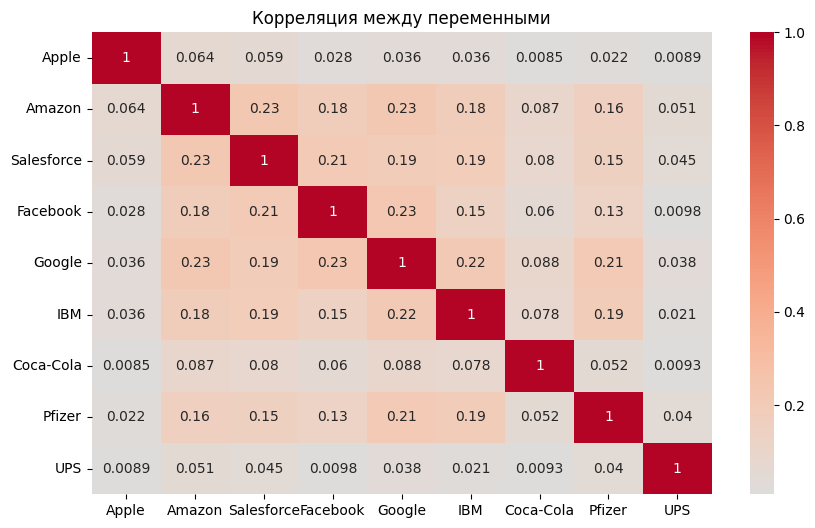


2. Временные ряды:


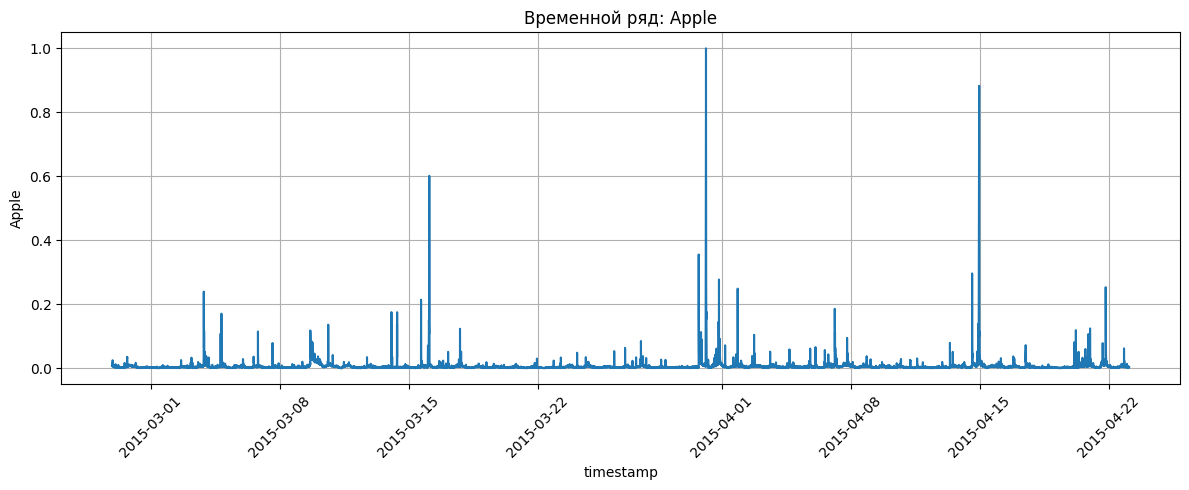

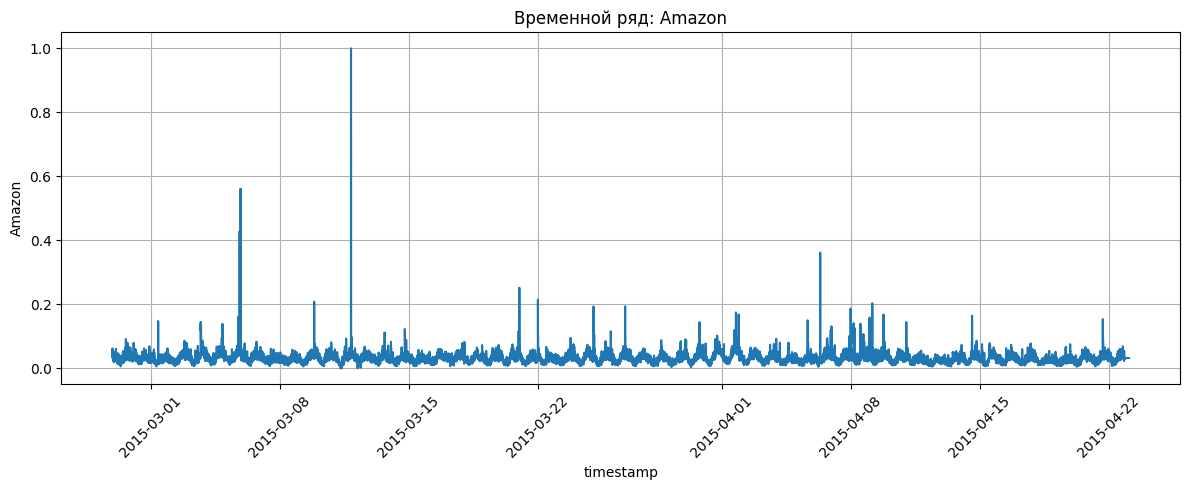

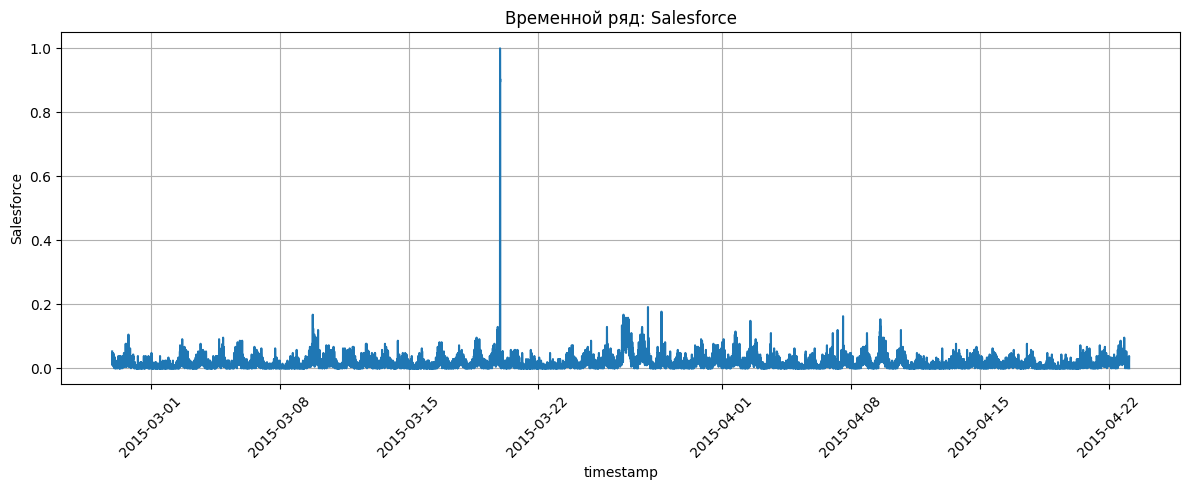

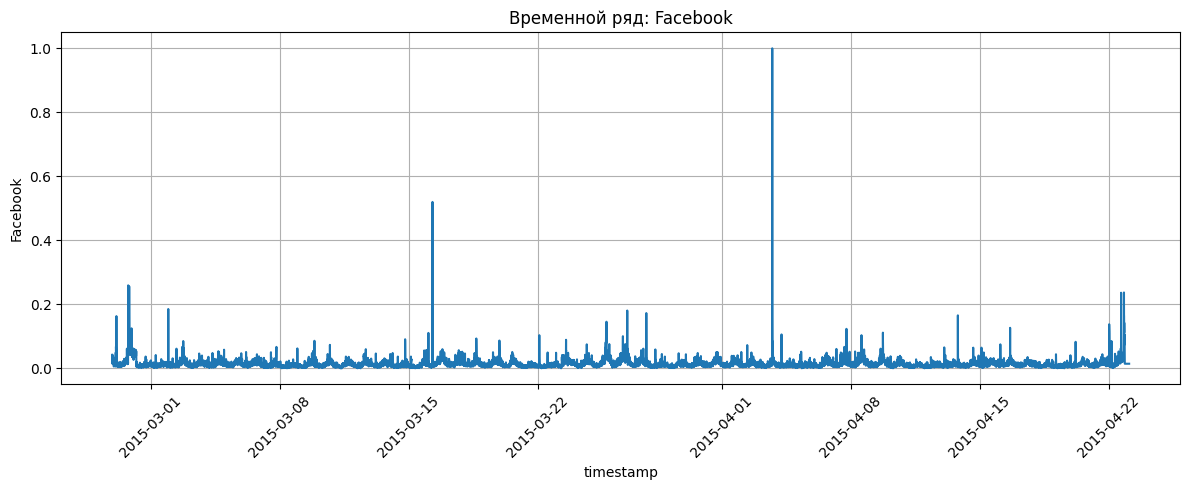

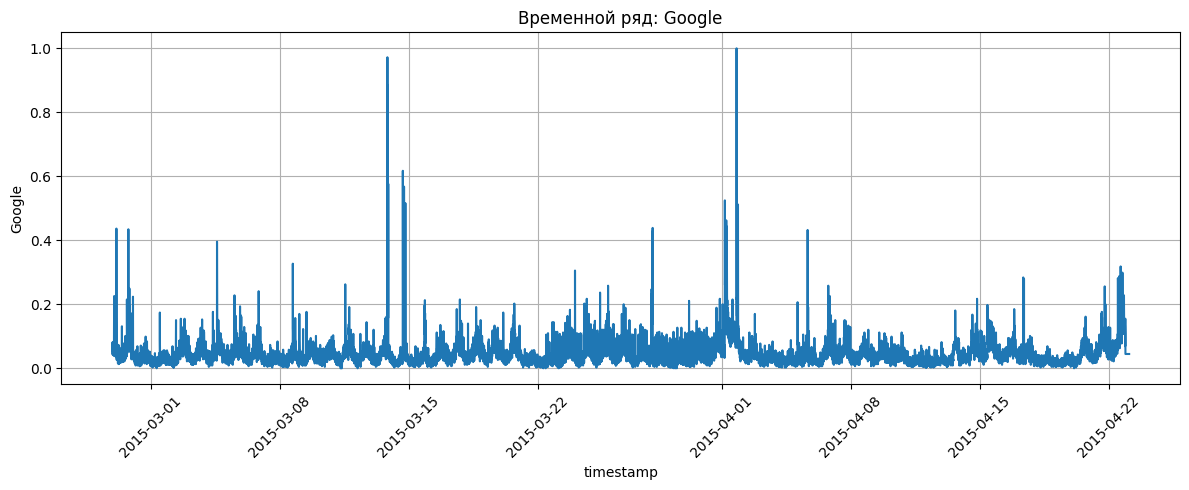

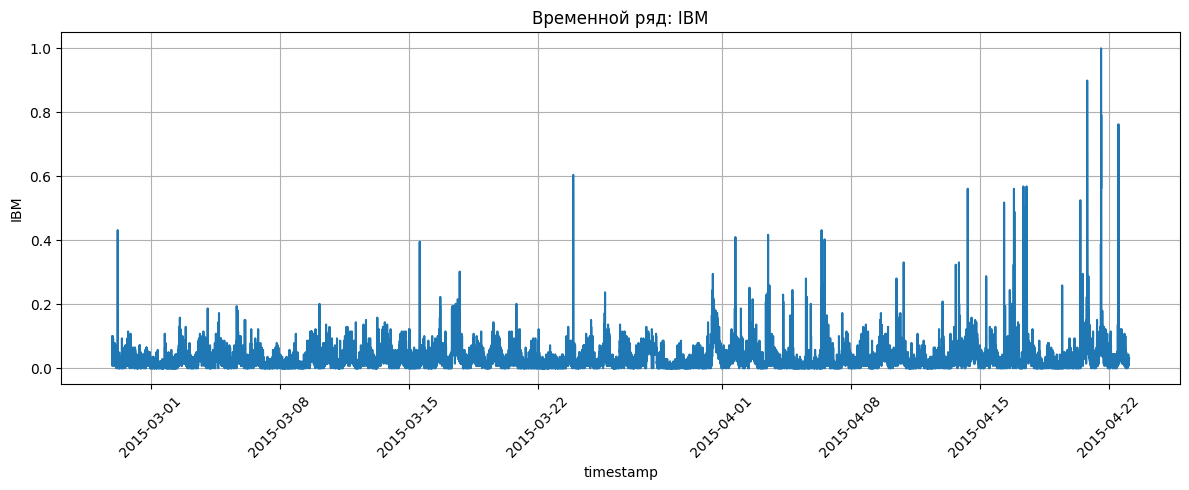

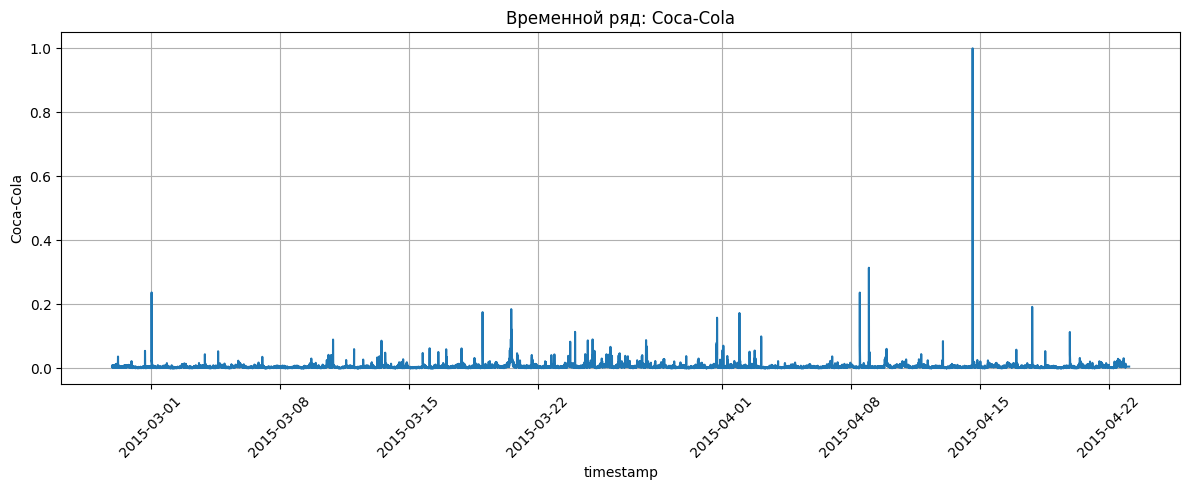

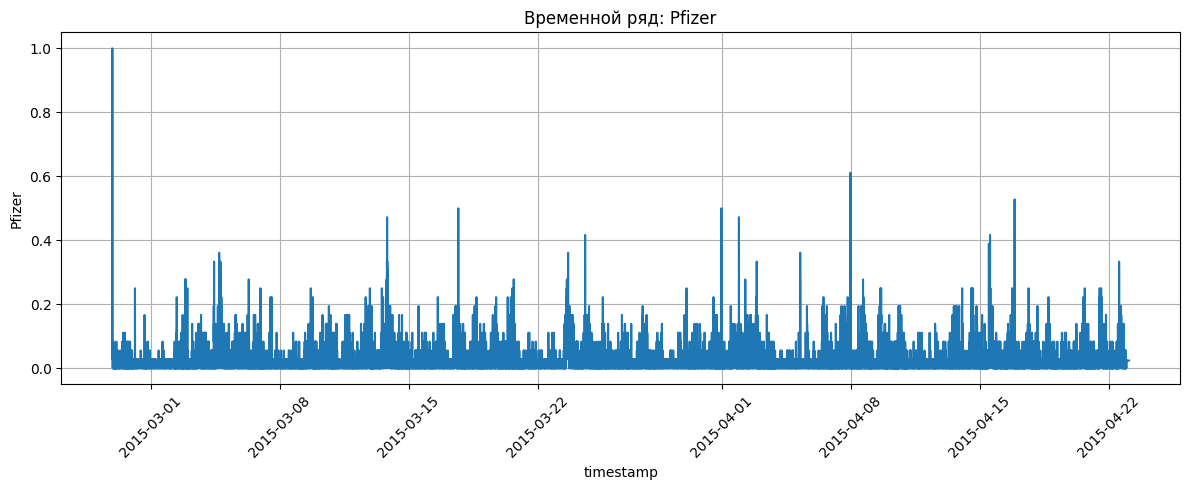

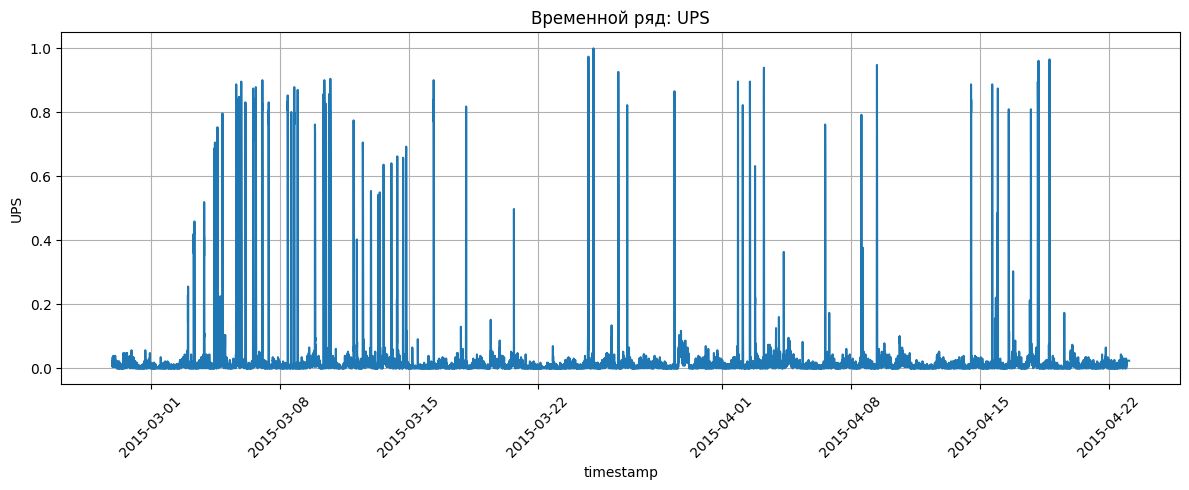


3. Распределения значений:


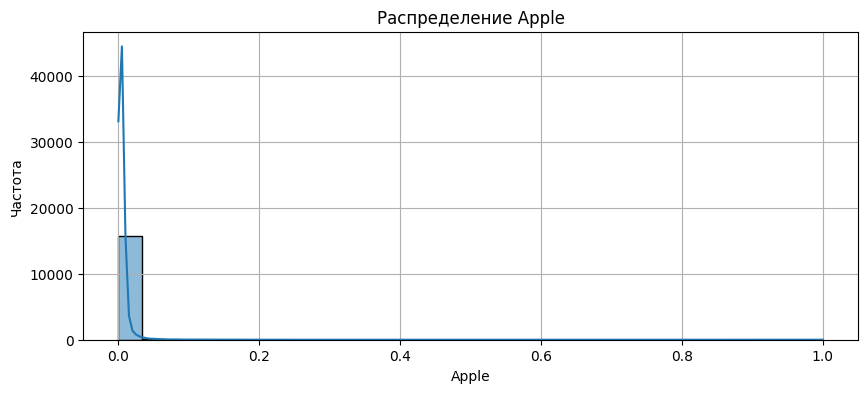

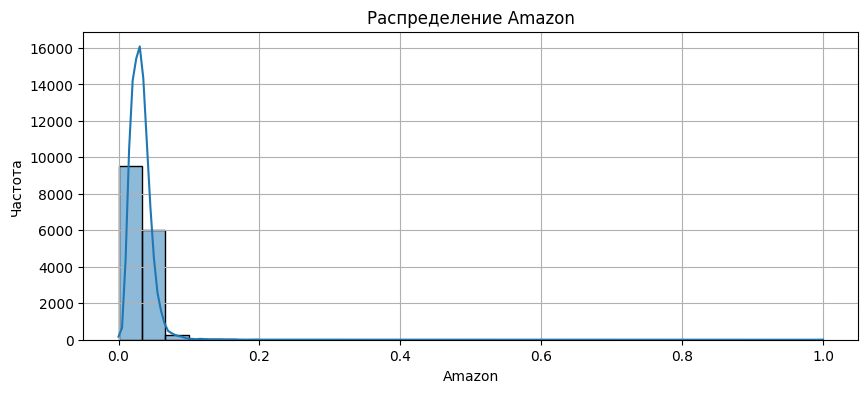

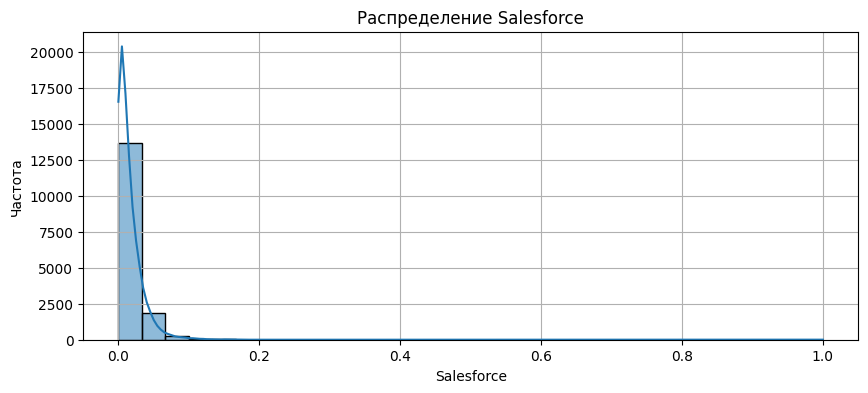

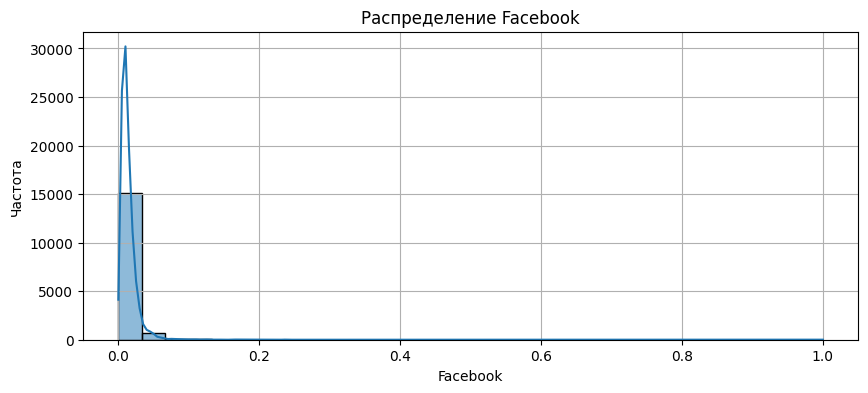

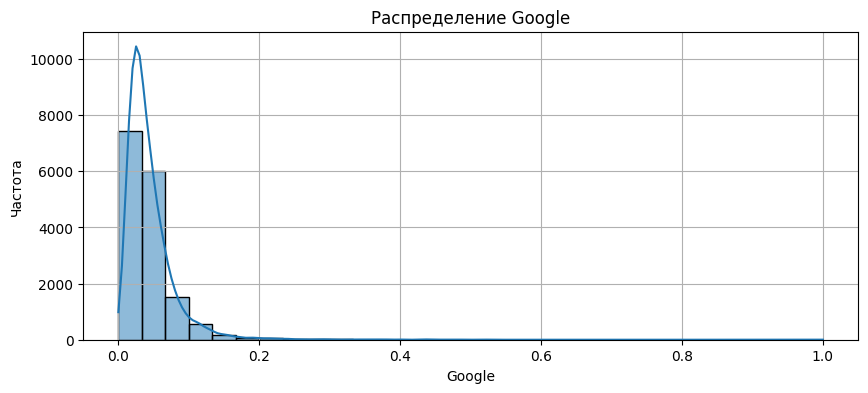

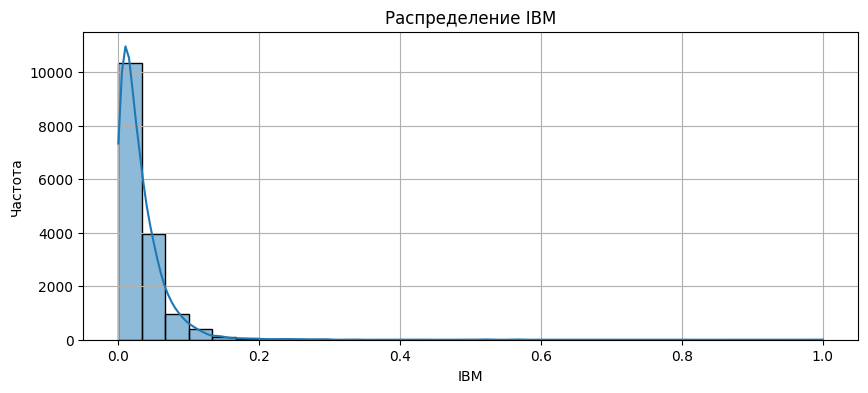

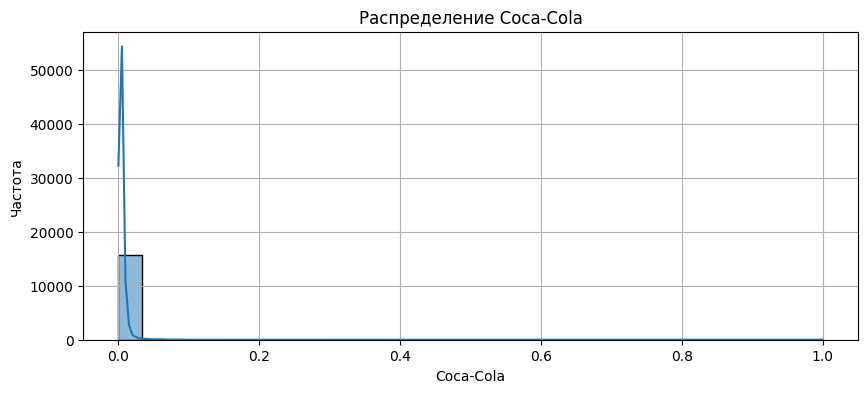

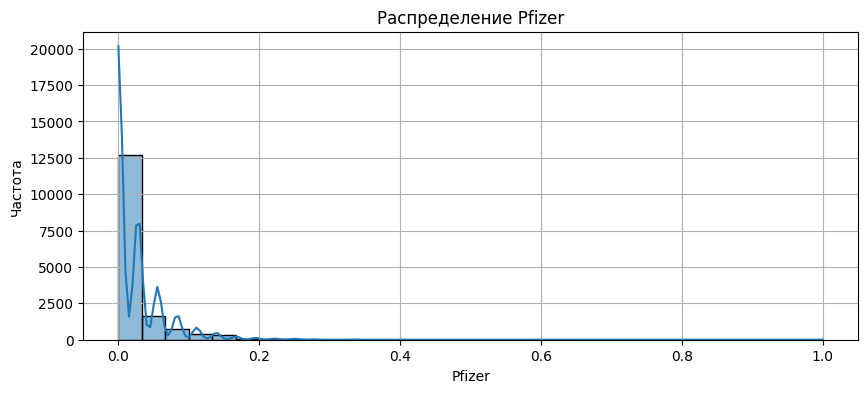

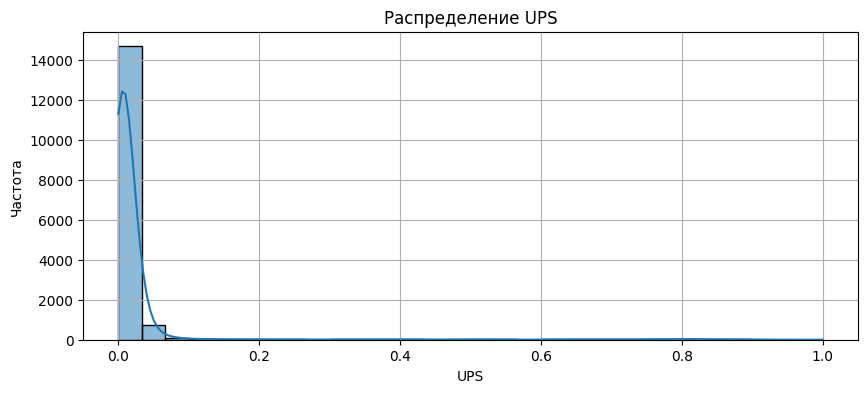


=== Обнаружение аномалий: IsolationForest ===


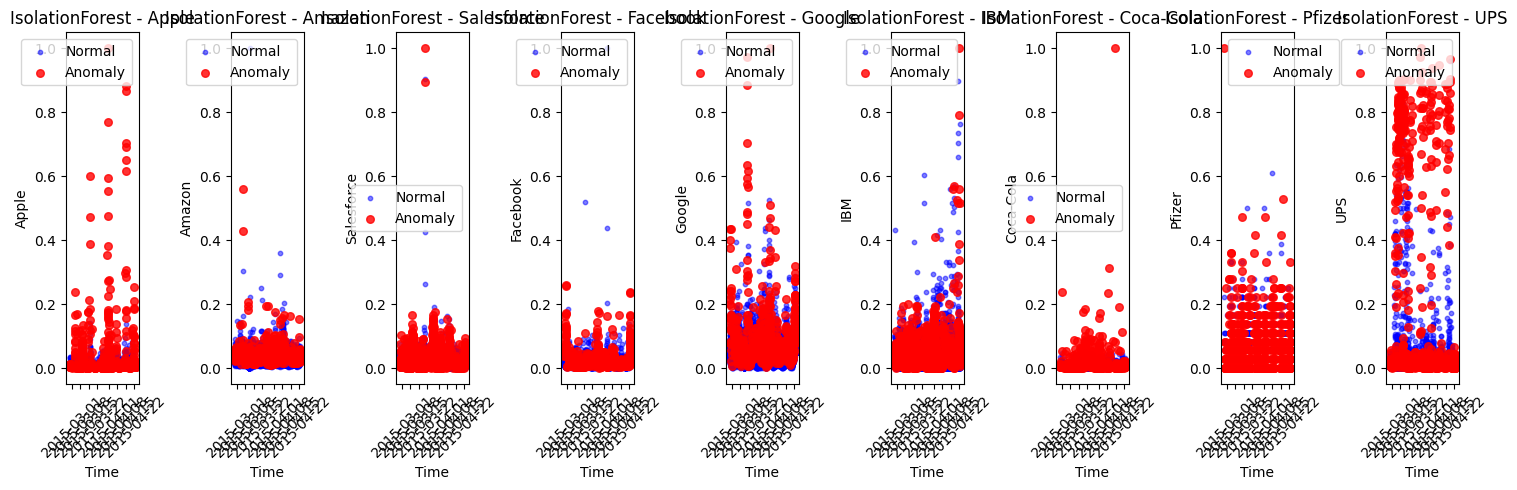

Удалено аномалий: 795 (5.00%)

=== Обнаружение аномалий: LOF ===


/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


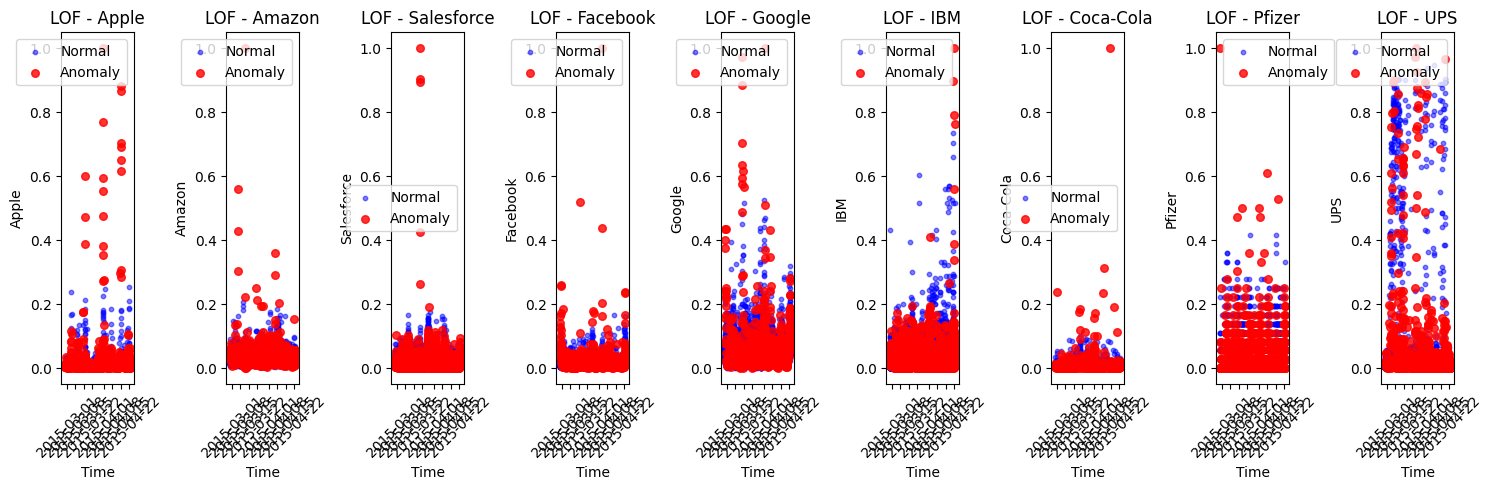

Удалено аномалий: 795 (5.00%)

=== Обнаружение аномалий: KNN ===


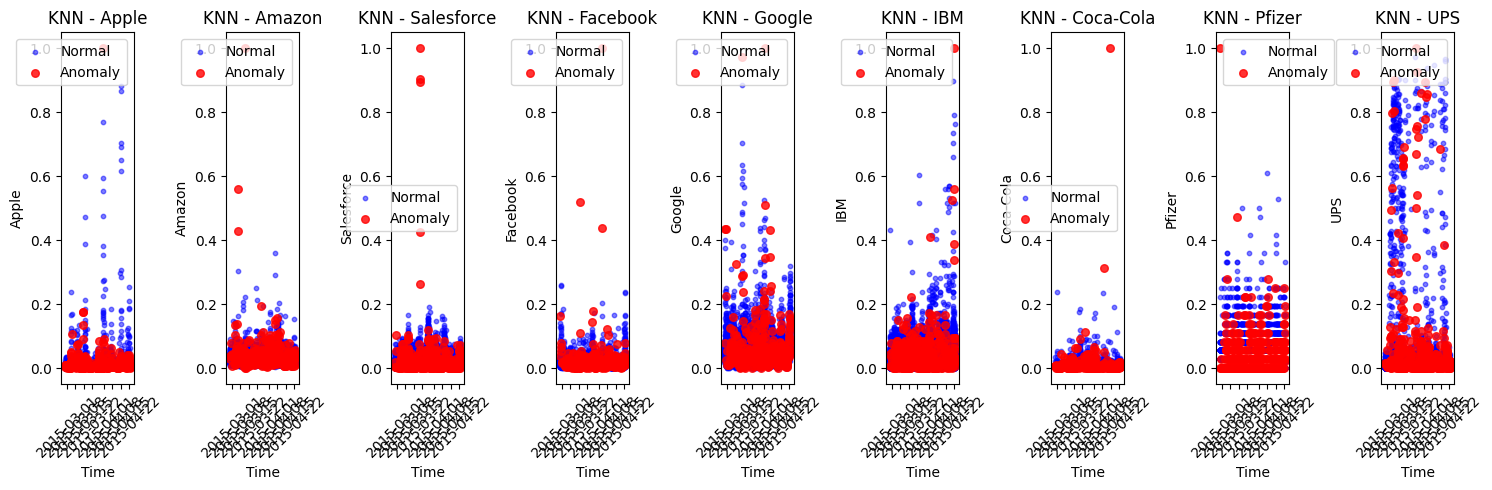

Удалено аномалий: 410 (2.58%)

=== Регрессионный анализ на исходных данных ===

=== Регрессионный анализ ===
Целевая переменная: timestamp
Независимые переменные: ['Apple', 'Amazon', 'Salesforce', 'Facebook', 'Google', 'IBM', 'Coca-Cola', 'Pfizer', 'UPS']

Model: MultiOutputLinearRegression
Training R^2 score: 0.020625298536501968
Testing R^2 score: 0.01991142752141073
Training RMSE: 1364710.566575352
Testing RMSE: 1358777.8984939521
Training AIC: 314472.84211002773
Testing AIC: 134771.0424144181

Model: MultiOutputElasticNet
Training R^2 score: 0.018165501865797462
Testing R^2 score: 0.0166810317435776
Training RMSE: 1366423.2947796634
Testing RMSE: 1361015.3388506237
Training AIC: 314500.7611625248
Testing AIC: 134786.7418877504

Model: MultiOutputGradientBoostingRegressor
Training R^2 score: 0.15085175657809857
Testing R^2 score: 0.09314995140994475
Training RMSE: 1270743.4248833358
Testing RMSE: 1307023.9680675224
Training AIC: 312884.8078359564
Testing AIC: 134400.49870124276

===

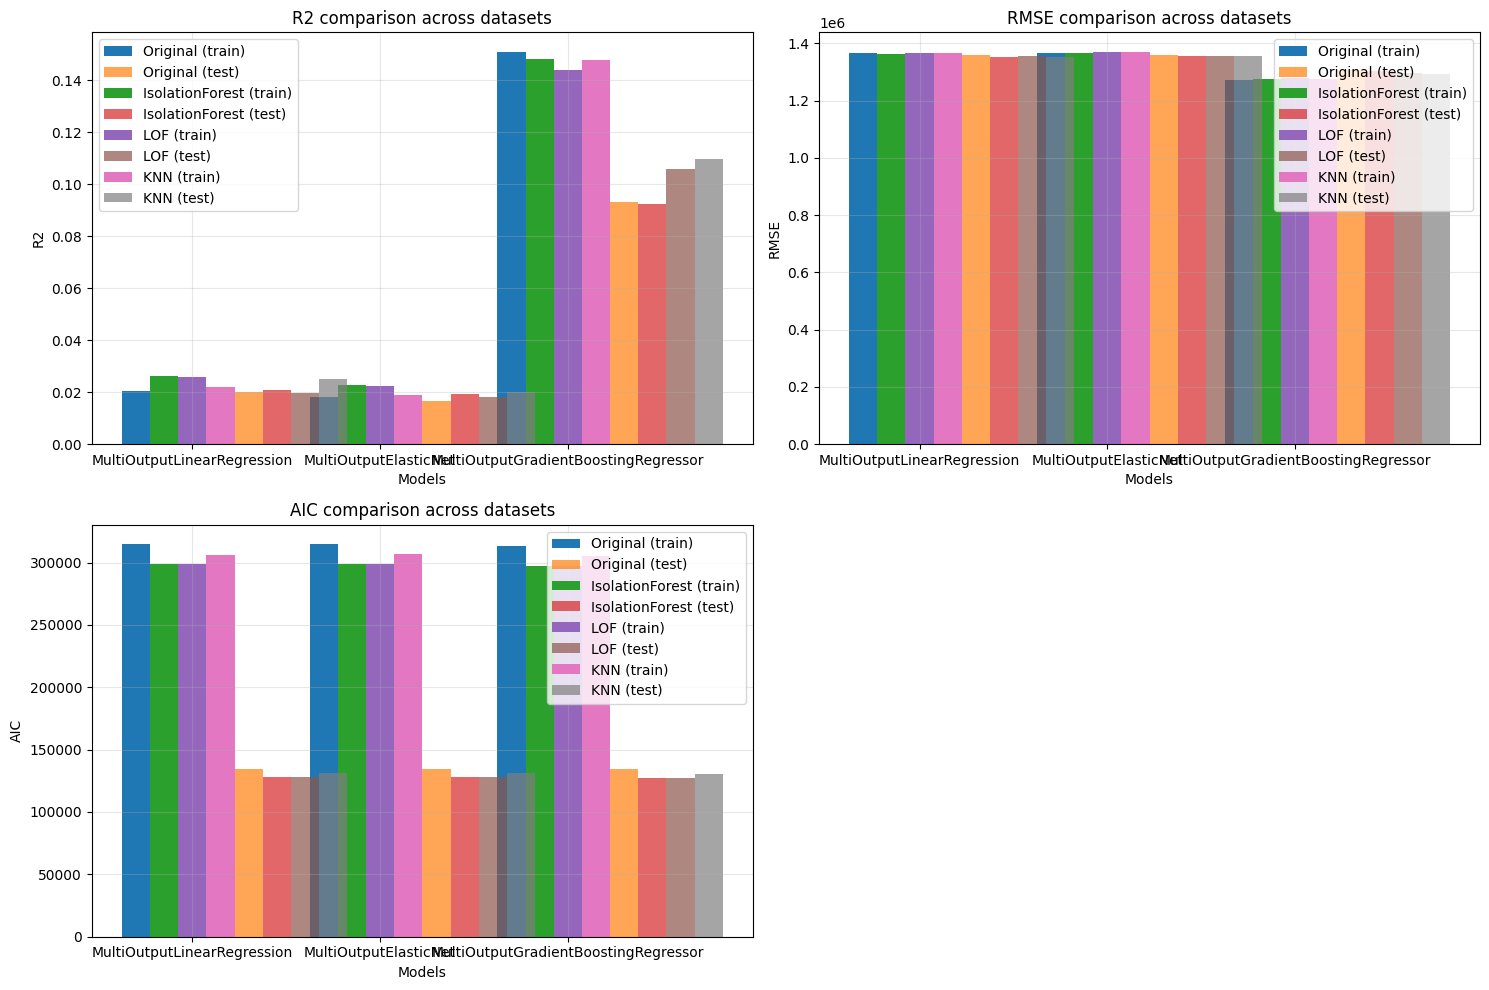

In [ ]:
import pandas as pd
import numpy as np
import io
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest, GradientBoostingRegressor
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.tools.eval_measures import aic
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor

def load_and_preprocess():
    """Загрузка и предобработка данных"""
    uploaded = files.upload()
    file_name = next(iter(uploaded))
    data = pd.read_csv(io.BytesIO(uploaded[file_name]))

    print(f"\nФайл '{file_name}' успешно загружен!")
    print(f"Исходный размер данных: {data.shape}")
    print("\nПервые 5 строк:")
    print(data.head())

    # Автоматическое преобразование даты
    for col in data.select_dtypes(include=['object']):
        try:
            data[col] = pd.to_datetime(data[col])
            print(f"\nСтолбец '{col}' преобразован в datetime")
        except:
            continue

    # Обработка пропусков
    if data.isnull().sum().sum() > 0:
        print("\nОбнаружены пропущенные значения:")
        print(data.isnull().sum())

        choice = input("\nВыберите обработку (1-заполнить средним, 2-удалить строки): ")
        if choice == '1':
            numeric = data.select_dtypes(include=[np.number])
            data[numeric.columns] = numeric.fillna(numeric.mean())
            non_numeric = data.select_dtypes(exclude=[np.number])
            data[non_numeric.columns] = non_numeric.fillna(non_numeric.mode().iloc[0])
            print("\nПропуски заполнены средними/модальными значениями!")
        else:
            data = data.dropna()
            print("\nСтроки с пропусками удалены!")

        print(f"\nОсталось пропусков: {data.isnull().sum().sum()}")

    print("\nДанные после обработки:")
    print(f"Размер: {data.shape}")
    return data

def select_variables(data):
    """Выбор переменных для анализа"""
    print("\nСписок столбцов:")
    for i, col in enumerate(data.columns, 1):
        print(f"{i}: {col} ({data[col].dtype})")

    # Выбор временной переменной (будет y)
    time_col = data.columns[int(input("\nВведите номер временного столбца: "))-1]

    # Выбор независимых переменных (будет X)
    feature_nums = input("Введите номера независимых переменных через запятую: ").split(',')
    features = [data.columns[int(num.strip())-1] for num in feature_nums]

    return data, time_col, features

def visualize_data(data, time_col, features):
    """Визуализация данных"""
    # 1. Матрица корреляций
    print("\n1. Матрица корреляций:")
    plt.figure(figsize=(10, 6))
    sns.heatmap(data[features].corr(), annot=True, cmap='coolwarm', center=0)
    plt.title("Корреляция между переменными")
    plt.show()

    # 2. Временные ряды (отдельно для каждой переменной)
    print("\n2. Временные ряды:")
    for feature in features:
        plt.figure(figsize=(12, 5))
        plt.plot(data[time_col], data[feature], label=feature)
        plt.title(f"Временной ряд: {feature}")
        plt.xlabel(time_col)
        plt.ylabel(feature)
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    # 3. Распределения значений (отдельно для каждой переменной)
    print("\n3. Распределения значений:")
    for feature in features:
        plt.figure(figsize=(10, 4))
        sns.histplot(data[feature], kde=True, bins=30)
        plt.title(f"Распределение {feature}")
        plt.xlabel(feature)
        plt.ylabel("Частота")
        plt.grid(True)
        plt.show()

def aic_custom(n, rss, k):
    """Кастомная функция для расчета AIC"""
    return n * np.log(rss / n) + 2 * k

def evaluate_model(model, X_train, X_test, y_train, y_test):
    """Оценка одной модели"""
    # Для мульти-таргет регрессии используем MultiOutputRegressor
    if not hasattr(model, 'n_outputs_'):
        model = MultiOutputRegressor(model)

    model.fit(X_train, y_train)

    # Предсказания
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Метрики (усредненные по всем таргетам)
    train_r2 = r2_score(y_train, y_train_pred, multioutput='uniform_average')
    test_r2 = r2_score(y_test, y_test_pred, multioutput='uniform_average')

    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred, multioutput='uniform_average'))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred, multioutput='uniform_average'))

    n_train = len(y_train)
    n_test = len(y_test)
    k = X_train.shape[1] * y_train.shape[1]  # Учитываем все коэффициенты для всех таргетов

    # Общая RSS для всех таргетов
    train_rss = np.sum((y_train - y_train_pred)**2)
    test_rss = np.sum((y_test - y_test_pred)**2)

    train_aic = aic_custom(n_train, train_rss, k)
    test_aic = aic_custom(n_test, test_rss, k)

    # Вывод результатов
    model_name = model.__class__.__name__
    if isinstance(model, MultiOutputRegressor):
        model_name = f"MultiOutput{model.estimator.__class__.__name__}"

    print(f"\nModel: {model_name}")
    print(f"Training R^2 score: {train_r2}")
    print(f"Testing R^2 score: {test_r2}")
    print(f"Training RMSE: {train_rmse}")
    print(f"Testing RMSE: {test_rmse}")
    print(f"Training AIC: {train_aic}")
    print(f"Testing AIC: {test_aic}")

    return {
        'Model': model_name,
        'Train R2': train_r2,
        'Test R2': test_r2,
        'Train RMSE': train_rmse,
        'Test RMSE': test_rmse,
        'Train AIC': train_aic,
        'Test AIC': test_aic
    }

def regression_analysis(data, time_col, features):
    """Регрессионный анализ с временем как целевой переменной"""
    # Преобразуем время в числовой формат (секунды от минимального времени)
    y = (data[time_col] - data[time_col].min()).dt.total_seconds().values.reshape(-1, 1)
    X = data[features].values

    # Масштабирование данных
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Разделение данных
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

    # Модели для оценки
    models = [
        LinearRegression(),
        ElasticNet(random_state=42),
        GradientBoostingRegressor(random_state=42)
    ]

    results = []

    print("\n=== Регрессионный анализ ===")
    print(f"Целевая переменная: {time_col}")
    print(f"Независимые переменные: {features}")

    for model in models:
        result = evaluate_model(model, X_train, X_test, y_train, y_test)
        results.append(result)

    return results

def detect_anomalies(data, time_col, features):
    """Обнаружение аномалий и создание очищенных датасетов"""
    X = data[features].values
    time_values = data[time_col]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    models = {
        'IsolationForest': IsolationForest(contamination=0.05, random_state=42),
        'LOF': LocalOutlierFactor(n_neighbors=20, contamination=0.05),
        'KNN': LocalOutlierFactor(n_neighbors=5, contamination=0.05, novelty=True)
    }

    clean_datasets = {}

    for name, model in models.items():
        print(f"\n=== Обнаружение аномалий: {name} ===")

        if name == 'KNN':
            model.fit(X_scaled)
            anomalies = model.predict(X_scaled)
        else:
            anomalies = model.fit_predict(X_scaled)

        # Создаем очищенный датасет
        clean_data = data.copy()
        clean_mask = anomalies == 1  # Сохраняем только нормальные точки
        clean_data = clean_data[clean_mask]
        clean_datasets[name] = clean_data

        # Визуализация
        plot_anomalies(time_values, X, anomalies, name, features)

        removed_percent = ((len(data) - len(clean_data))/len(data)*100)
        print(f"Удалено аномалий: {len(data) - len(clean_data)} ({removed_percent:.2f}%)")

    return clean_datasets

def plot_anomalies(time_values, X, anomalies, method_name, features):
    """Визуализация аномалий"""
    plt.figure(figsize=(15, 5))

    for i, feature in enumerate(features):
        plt.subplot(1, len(features), i+1)

        normal = anomalies == 1
        abnormal = anomalies == -1

        plt.scatter(time_values[normal], X[normal, i],
                   c='blue', alpha=0.5, s=10, label='Normal')
        plt.scatter(time_values[abnormal], X[abnormal, i],
                   c='red', alpha=0.8, s=30, label='Anomaly')

        plt.title(f"{method_name} - {feature}")
        plt.xlabel("Time")
        plt.ylabel(feature)
        plt.xticks(rotation=45)
        plt.legend()

    plt.tight_layout()
    plt.show()

def compare_models_on_clean_data(original_data, clean_datasets, time_col, features):
    """Сравнение моделей на оригинальных и очищенных данных"""
    all_results = {}

    # 1. Регрессия на оригинальных данных
    print("\n=== Регрессионный анализ на исходных данных ===")
    original_results = regression_analysis(original_data, time_col, features)
    all_results['Original'] = original_results

    # 2. Регрессия на очищенных данных
    for method, clean_data in clean_datasets.items():
        print(f"\n=== Регрессионный анализ после {method} ===")
        method_results = regression_analysis(clean_data, time_col, features)
        all_results[method] = method_results

    # Итоговая визуализация
    plot_final_comparison(all_results)

def plot_final_comparison(all_results):
    """Итоговая визуализация сравнения метрик"""
    datasets = list(all_results.keys())
    models = [res['Model'] for res in all_results[datasets[0]]]
    metrics = ['R2', 'RMSE', 'AIC']

    plt.figure(figsize=(15, 10))

    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 2, i)

        # Сбор данных для текущей метрики
        train_values = []
        test_values = []
        for dataset in datasets:
            train_row = [res[f'Train {metric}'] for res in all_results[dataset]]
            test_row = [res[f'Test {metric}'] for res in all_results[dataset]]
            train_values.append(train_row)
            test_values.append(test_row)

        # Построение графиков
        width = 0.15
        x = np.arange(len(models))

        for j, dataset in enumerate(datasets):
            plt.bar(x + j*width, train_values[j], width, label=f'{dataset} (train)')
            plt.bar(x + j*width + len(datasets)*width, test_values[j], width,
                   label=f'{dataset} (test)', alpha=0.7)

        plt.xlabel('Models')
        plt.ylabel(metric)
        plt.title(f'{metric} comparison across datasets')
        plt.xticks(x + width*len(datasets)/2, models)
        plt.legend()
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def main():
    print("=== Полный анализ временных рядов ===")

    # 1. Загрузка и предобработка
    data = load_and_preprocess()

    # 2. Выбор переменных
    data, time_col, features = select_variables(data)

    # 3. Визуализация данных
    visualize_data(data, time_col, features)

    # 4. Обнаружение аномалий и создание очищенных датасетов
    clean_datasets = detect_anomalies(data, time_col, features)

    # 5. Сравнение моделей на разных датасетах
    compare_models_on_clean_data(data, clean_datasets, time_col, features)

if __name__ == "__main__":
    main()